# Movie Recommendation System With Item-Based Collaborative Filtering 

<b> Recommendation system </b> is a subclass of information filtering system that seeks to predict the "rating" or "preference" a user would give to an item.

<b> Item-based collaborative filtering </b> - is a form of collaborative filtering for recommender systems based on the similarity between items calculated using people's ratings of those items.

# 1 Import nessesary libraries and modules

In [1]:
from pyspark.sql import SparkSession,Row
from pyspark.sql import functions as f
from pyspark.ml.linalg import Vectors
from pyspark.ml import feature
from pyspark.ml.feature import CountVectorizer
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

# 2 Start Spark session

In [2]:
spark = SparkSession.builder.appName('my_app').master("local[*]").getOrCreate()

# 3  Create movie names and movie categories lookup tables

## 3.1 Define helper functions

In [3]:
def parseMovieLine(line):
    '''parse single line from movies.csv'''
    items = line.split(',', maxsplit=1)
    movieId = int(items[0])
    residue = items[1]
    if residue[0] == '"':
        residueSplitted = residue.split('"')
        movieName = residueSplitted[1]
        categories = residueSplitted[2].split('|')[1:]
    else:
        residueSplitted = residue.split(',')
        movieName = residueSplitted[0]
        categories = residueSplitted[1].split('|')
    return movieId, movieName, categories

## 3.2 Create movie dataframe

In [4]:
movieRdd = spark.sparkContext.textFile("./ml-latest-small/movies.csv")

# cache rdd for many applications
movieRddParsed = movieRdd.map(parseMovieLine).cache()
movieDataFrame = spark.createDataFrame(movieRddParsed).toDF('id', 'name', 'categories')
movieDataFrame.show()

+---+--------------------+--------------------+
| id|                name|          categories|
+---+--------------------+--------------------+
|  1|    Toy Story (1995)|[Adventure, Anima...|
|  2|      Jumanji (1995)|[Adventure, Child...|
|  3|Grumpier Old Men ...|   [Comedy, Romance]|
|  4|Waiting to Exhale...|[Comedy, Drama, R...|
|  5|Father of the Bri...|            [Comedy]|
|  6|         Heat (1995)|[Action, Crime, T...|
|  7|      Sabrina (1995)|   [Comedy, Romance]|
|  8| Tom and Huck (1995)|[Adventure, Child...|
|  9| Sudden Death (1995)|            [Action]|
| 10|    GoldenEye (1995)|[Action, Adventur...|
| 11|American Presiden...|    [Drama, Romance]|
| 12|Dracula: Dead and...|    [Comedy, Horror]|
| 13|        Balto (1995)|[Adventure, Anima...|
| 14|        Nixon (1995)|             [Drama]|
| 15|Cutthroat Island ...|[Action, Adventur...|
| 16|       Casino (1995)|      [Crime, Drama]|
| 17|Sense and Sensibi...|    [Drama, Romance]|
| 18|   Four Rooms (1995)|            [C

## 3.3 Convert 'categories' column to numeric one-hot-encoding vector

### 3.3.1 Get unique movie categories

In [5]:
categories = movieRddParsed.flatMap(lambda items: [category for category in items[2]]).distinct().collect()
# drop category no' genres listed'
categories.remove('(no genres listed)')
print(categories)

['Children', 'Fantasy', 'Romance', 'Drama', 'Action', 'Thriller', 'Horror', 'Sci-Fi', 'Musical', 'Documentary', 'IMAX', 'Western', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Mystery', 'War', 'Film-Noir']


### 3.3.2 Transform string category vector to sparse one-hot-encoding vector  using CountVectorizer

In [6]:
cv = CountVectorizer(inputCol='categories', outputCol='categoriesVec', vocabSize=len(categories))

cvModel = cv.fit(movieDataFrame)
movieDataFrame = cvModel.transform(movieDataFrame)
movieDataFrame = movieDataFrame.drop('categories')
movieDataFrame.show(n=3,truncate=False, vertical=True)

-RECORD 0-------------------------------------------------
 id            | 1                                        
 name          | Toy Story (1995)                         
 categoriesVec | (19,[1,5,9,10,12],[1.0,1.0,1.0,1.0,1.0]) 
-RECORD 1-------------------------------------------------
 id            | 2                                        
 name          | Jumanji (1995)                           
 categoriesVec | (19,[5,9,10],[1.0,1.0,1.0])              
-RECORD 2-------------------------------------------------
 id            | 3                                        
 name          | Grumpier Old Men (1995)                  
 categoriesVec | (19,[1,3],[1.0,1.0])                     
only showing top 3 rows



## 3.4 Create movie name lookup table as dictionary {movieId : movieName}

In [7]:
movieNameDataFrame = movieDataFrame.select('id', 'name')
movieNameDict = dict(movieNameDataFrame.toPandas().values)

# save name dict for future use
with open('movieNameDict.pickle', 'wb') as f:
    # pickle the 'models'using the highest protocol available.
    pickle.dump(movieNameDict, f, pickle.HIGHEST_PROTOCOL)

# load previously saved name dict to check correctivness of serialize/deserialize processes
with open('movieNameDict.pickle', 'rb') as f:
    movieNameDict = pickle.load(f)

# show some example
for i in range(1,11):
    print(i, movieNameDict[i])

1 Toy Story (1995)
2 Jumanji (1995)
3 Grumpier Old Men (1995)
4 Waiting to Exhale (1995)
5 Father of the Bride Part II (1995)
6 Heat (1995)
7 Sabrina (1995)
8 Tom and Huck (1995)
9 Sudden Death (1995)
10 GoldenEye (1995)


## 3.5 Create movie category lookup table as dictionary {movieId : categoriesVec}

In [8]:
movieCategoryDataFrame = movieDataFrame.select('id', 'categoriesVec')
movieCategoryDict = dict(movieCategoryDataFrame.toPandas().values)

# show some example
for i in range(1,11):
    print(i, movieCategoryDict[i])

1 (19,[1,5,9,10,12],[1.0,1.0,1.0,1.0,1.0])
2 (19,[5,9,10],[1.0,1.0,1.0])
3 (19,[1,3],[1.0,1.0])
4 (19,[0,1,3],[1.0,1.0,1.0])
5 (19,[1],[1.0])
6 (19,[2,4,6],[1.0,1.0,1.0])
7 (19,[1,3],[1.0,1.0])
8 (19,[5,10],[1.0,1.0])
9 (19,[4],[1.0])
10 (19,[2,4,5],[1.0,1.0,1.0])


# 4 Create RDD of movie similarities

## 4.1 Define helper functions

In [9]:
def parseRatingLine(line):
    '''parse single line from movies.csv'''
    userId, movieId, rating = line.split(',')[:3]
    return int(userId), ( int(movieId), float(rating) )


def filterPopularMovies(line, movieCounter):
    '''filter out movies below counter threshold'''
    counter = line[1]
    return counter >= movieCounter


def filterDuplicates(userRatings):
    '''fitler out duplicate movies ratings'''
    ratings = userRatings[1]
    movie1, rating1 = ratings[0]
    movie2, rating2 = ratings[1]
    return movie1 < movie2


def makePairs(userRatings):
    '''make every movie rating pairs'''
    ratings = userRatings[1]
    movie1, rating1 = ratings[0]
    movie2, rating2 = ratings[1]
    return (movie1, movie2), (rating1, rating2)


def addCatVec(items, movieDict):
    '''add category vector to RDD'''
    key, value = items
    return (key, (value, (movieDict[key[0]], movieDict[key[1]]) ) )

def computeSimilarity(items):
    '''compute similarity between movie ratings'''
    
    ratingPairs, categoryVectors = items
    categoryVectorX, categoryVectorY = categoryVectors
    
    ratingsX, ratingsY, numPairs = [], [], 0
    for ratingX, ratingY in ratingPairs:
        ratingsX.append(ratingX)
        ratingsY.append(ratingY)
        numPairs += 1
    
    movieSim = float(np.dot(ratingsX, ratingsY) / (np.linalg.norm(ratingsX) * np.linalg.norm(ratingsY)))
    catSim = float(np.dot(categoryVectorX, categoryVectorY) / (np.linalg.norm(categoryVectorX) 
                                                             * np.linalg.norm(categoryVectorX))) 

    return (movieSim, catSim, numPairs)

## 4.2 Create a list of popular movies

I don't want to have movies in recommendation system, that have been rated less than 50 times

In [10]:
# create ratings RDD
ratingRdd = spark.sparkContext.textFile("./ml-latest-small/ratings.csv")
# cache rdd for future applications
ratingRddParsed = ratingRdd.map(parseRatingLine).cache()


# set a occurence threshold for popular film
OCURRENCE_THRESHOLD = 50

# create popular movie list
POPULAR_MOVIES_LIST = ratingRddParsed.map( lambda x: (x[1][0], 1) )\
                                      .reduceByKey(lambda x,y: x+y)\
                                      .filter(lambda x: filterPopularMovies(x, OCURRENCE_THRESHOLD))\
                                      .sortByKey()\
                                      .map(lambda x: x[0])\
                                      .collect()

# show first 50 movie ID
print(POPULAR_MOVIES_LIST[:50])

[1, 2, 3, 6, 7, 10, 11, 16, 17, 19, 21, 25, 32, 34, 36, 39, 47, 48, 50, 62, 70, 95, 104, 110, 111, 141, 145, 150, 153, 158, 160, 161, 163, 165, 168, 172, 173, 185, 208, 223, 225, 231, 235, 253, 260, 266, 288, 292, 293, 296]


## 4.3 Create movie similarities (cosine metric) RDD

In [11]:
# filter out ratings for not popular movies
filteredRatings = ratingRddParsed.filter(lambda x: x[1][0] in POPULAR_MOVIES_LIST)

# partition data before high computable task to speed it up
filteredRatings = filteredRatings.partitionBy(2) # 2 => number of my virtual machine core

# emit every movie rated together by the same user
# self-join to find every combination
joinedRatings = filteredRatings.join(filteredRatings)

# at this point RDD consists: userID => ((movieID, rating), (movieID, rating))
# filter out duplicate pairs
uniqueJoinedRatings = joinedRatings.filter(filterDuplicates)

# create key as (movieId1, movieId2) pairs.
moviePairs = uniqueJoinedRatings.map(makePairs)

# at this point RDD consists: (movie1, movie2) => (rating1, rating2)
# collect all ratings for each movie pair
moviePairRatings = moviePairs.groupByKey()

# add category vector to RDD
moviePairRatingsCat = moviePairRatings.map(lambda x: addCatVec(x, movieCategoryDict))
moviePairRatingsCat.collect()[0]

# at this point RDD consists: (movieId1, movieId2) => ( (rank1, rank2), ... ), (catVec1, catVec2))
# compute similarities between ratings and movie categories
moviePairSimilarities = moviePairRatingsCat.mapValues(computeSimilarity).cache()

# at this point RDD consists: (movieId1, movieId2) => (rating-similarity, type-similarity, coOccurence)
# show some example
moviePairSimilarities.collect()[:10]

[((318, 1704), (0.9824253724777434, 1.0, 111)),
 ((318, 3578), (0.9668795474112983, 1.0, 107)),
 ((318, 6874), (0.9706550101840915, 0.0, 101)),
 ((318, 48516), (0.9874014311767221, 1.0, 88)),
 ((318, 74458), (0.974999809417599, 1.0, 51)),
 ((318, 79132), (0.9773711830275497, 1.0, 105)),
 ((318, 99114), (0.9742786825968885, 1.0, 56)),
 ((318, 106782), (0.9744519580567291, 1.0, 40)),
 ((333, 58559), (0.9813378255725722, 0.0, 15)),
 ((333, 68157), (0.9865970694027583, 0.0, 10))]

# 5 Set similarity thresholds for movie ratings, category and co occurrence

I don't want to have a movie pairs in the recommendation system, that aren't similar to each other and havn't been rated jointly by at least several dozen users

## 5.1 Define helper functions

In [12]:
def getScores(line):
    '''extract score similarity, type similarity and coocurence from RDD'''
    return line[1][0], line[1][1], line[1][2]

## 5.2 Create movie similarity scores dataframe

In [13]:
movieSimilarity = moviePairSimilarities.map(getScores)
movieSimilarityDataFrame = spark.createDataFrame(movieSimilarity).toDF('score', 'type', 'cooccurence')
movieSimilarityDataFrame.collect()[:5]

[Row(score=0.9824253724777434, type=1.0, cooccurence=111),
 Row(score=0.9668795474112983, type=1.0, cooccurence=107),
 Row(score=0.9706550101840915, type=0.0, cooccurence=101),
 Row(score=0.9874014311767221, type=1.0, cooccurence=88),
 Row(score=0.974999809417599, type=1.0, cooccurence=51)]

## 5.3 Select movie rating similarity threshold

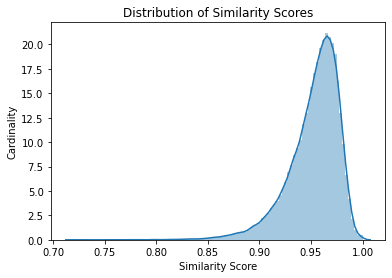

In [14]:
# show train reconstrucion losses distribution
plt.title('Distribution of Similarity Scores')
sns.distplot(movieSimilarityDataFrame.select('score').collect(), bins=100, kde=True)
plt.ylabel('Cardinality')
plt.xlabel('Similarity Score');

In [15]:
# refer to above plot and intuition I select similarity score threshold above 0.9
SCORE_THRESHOLD = 0.9

## 5.4 Select movie type similarity threshold

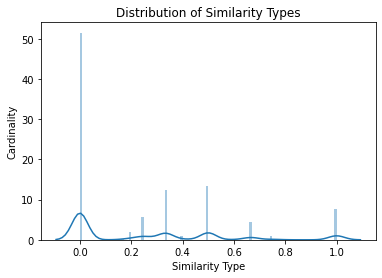

In [16]:
# show train reconstrucion losses distribution
plt.title('Distribution of Similarity Types')
sns.distplot(movieSimilarityDataFrame.select('type').collect(), bins=100, kde=True)
plt.ylabel('Cardinality')
plt.xlabel('Similarity Type');

In [17]:
# refer to above plot and intuition I select similarity type threshold above 0 (at least one common category)
CATEGORY_THRESHOLD = 0

## 5.5 Select cooccurence threshold

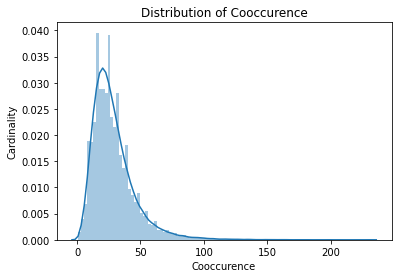

In [18]:
# show train reconstrucion losses distribution
plt.title('Distribution of Cooccurence')
sns.distplot(movieSimilarityDataFrame.select('cooccurence').collect(), bins=100, kde=True)
plt.ylabel('Cardinality')
plt.xlabel('Cooccurence');

In [19]:
# refer to above plot and intuition I select cooccurence threshold above 20 
COOCCURENCE_THRESHOLD = 20

## 6 Create final movie pair similarities RDD

In [20]:
# filter for movies with this sim that are "good" as defined by quality thresholds
reducedMoviePairSimilarities = moviePairSimilarities.filter(lambda x: x[1][0] > SCORE_THRESHOLD
                                                                  and x[1][1] > CATEGORY_THRESHOLD
                                                                  and x[1][2] > COOCCURENCE_THRESHOLD).cache()

## 7 Save final RDD to file for future use

In [21]:
reducedMoviePairSimilarities.saveAsPickleFile('MoviePairSimilarities')
reducedMoviePairSimilarities = spark.sparkContext.pickleFile('MoviePairSimilarities')

## 8 Create recommendation system

<b> Assumptions of the recommendation system: </b>
- for each user rated movie, select n (default = 5) most similar movies
- collect all movies and sort them by similarity rating metric (cosine)
- recommend max n (default = 10) movies, avoid duplicates and movies, that user has already seen

In [29]:
class RecommendationSystem():
    '''movie recomendation system'''
    
    def __init__(self, moviePairRdd, movieNameDict, totalRecommendations, singleRecommendation):
 
        self.moviePairRdd = moviePairRdd
        self.totalRecommendations = totalRecommendations
        self.singleRecommendation = singleRecommendation
        self.movieNameDict = movieNameDict
    
    def makeRecomendation(self, userRatings):
        '''driver function for recommendation'''
        
        # create list of similiraties for all user watched films
        movieSimScores, movieSimTypes, movieCoOccurences,\
        movieNames, movieRecomendedBy = self.createSimLists(userRatings)

        
        # sort lists by similiry score ratings
        sortedMovieSimScores, sortedMovieSimTypes, sortedMovieCoOccurences,\
        sortedMovieNames, sortedMovieRecomendedBy = self.sortSimLists(movieSimScores, movieSimTypes, 
                                                    movieCoOccurences, movieNames, movieRecomendedBy)
        
        # placeholder to control movie recomendations for user
        recommendations = []

        # iterate over all recomended film
        for name, simScore, simType, coOccurence, recomendedBy in zip(sortedMovieNames, 
                                                                      sortedMovieSimScores, 
                                                                      sortedMovieSimTypes,
                                                                      sortedMovieCoOccurences,
                                                                      sortedMovieRecomendedBy):
            # to avoid duplicates in recommendations
            if name not in recommendations:
                
                # show remomended films
                self.showRecommendation(len(recommendations)+1,
                                        name,
                                        recomendedBy,
                                        simScore,
                                        simType,
                                        coOccurence)
                
                recommendations.append(name)

                if len(recommendations) == self.totalRecommendations:
                    break
                    
                    
    def createSimLists(self, userRatings):
        '''create lists of movie similarities'''
        
        # create empty placeholders
        movieNames = []
        movieSimScores = []
        movieSimTypes = []
        movieCoOccurences =[]
        movieRecomendedBy = []
        
        # iterate over all user's watched film
        for movieId, rating in userRatings.items():
            # filter for movie pair contain user rated movie
            filteredMovies = self.moviePairRdd.filter(lambda x: (x[0][0] == movieId or x[0][1] == movieId) )

            # take only n best recommendation for each user movie
            recomendedMovies = filteredMovies.sortBy(lambda x: x[1][0], ascending = False)\
                                             .take(self.singleRecommendation)

            for recomendedMovie in recomendedMovies:
                
                movieKeys, simScores = recomendedMovie

                if movieId == movieKeys[0]:
                    similarMovieId = movieKeys[1]
                else:
                    similarMovieId = movieKeys[0]

                # don't recomend movies, that the user has already seen
                if similarMovieId not in userRatings.keys():
                    
                    # append similarity score multiple by user's rating for watched movie
                    movieSimScores.append(simScores[0]*rating)
                    # append category similarity
                    movieSimTypes.append(simScores[1])
                    # append movie coocurence
                    movieCoOccurences.append(simScores[2])
                    # append recomended movie name
                    movieNames.append(self.movieNameDict[similarMovieId])
                    # append user movie name thanks to whom this film was recommended
                    movieRecomendedBy.append(self.movieNameDict[movieId])
            
        return movieSimScores, movieSimTypes, movieCoOccurences, movieNames, movieRecomendedBy
        
        
    def sortSimLists(self, movieSimScores, movieSimTypes, movieCoOccurences,
                     movieNames, movieRecomendedBy):
        '''sort lists by similiry score ratings'''
        
        # reverse sort recomended movies by similarity score            
        movieSimScores = np.array(movieSimScores)
        idx = np.argsort(movieSimScores)[::-1]

        # reorder items in placeholders using numpy array properties
        movieSimScores = movieSimScores[idx]     
        movieSimTypes = np.array(movieSimTypes)[idx] 
        movieCoOccurences = np.array(movieCoOccurences)[idx] 
        movieNames = np.array(movieNames)[idx]
        movieRecomendedBy = np.array(movieRecomendedBy)[idx] 
        
        # convert back to lists
        return list(movieSimScores), list(movieSimTypes), list(movieCoOccurences),\
               list(movieNames), list(movieRecomendedBy)

            
    def showRecommendation(self, counter, movieName, recomendedMovieName, 
                           movieSimScore, movieSimType, movieCoOccurence):
        ''' show single movie recomendation'''

        print(f'Recomended Movie #{counter}',
              f'Title: {movieName}',
              f'Similarity Score: {round(movieSimScore,4)}',
              f'Similarity Types: {round(movieSimType,4)}', 
              f'Cooccurence: {movieCoOccurence}',
              f'Recommended by: {recomendedMovieName}',
              '-'*100, sep='\n')

# 9 Test recommendation system

Create 3 fictitious users and evaluate a recommendation system based on the movies proposed to them

## 9.1 Create recomendation system object

In [37]:
rs = RecommendationSystem(reducedMoviePairSimilarities, 
                          movieNameDict, 
                          totalRecommendations=10, 
                          singleRecommendation=5)

## 9.2 Test #1

<b> User rated movies </b>:
- <i> Lord of the Rings: The Two Towers, The (2002) </i> on <b> 5 stars </b>
- <i> Kill Bill: Vol. 1 (2003) </i> on <b> 5 stars </b> 
- <i> Harry Potter and the Chamber of Secrets (2002) </i> on <b> 1 stars </b>

<b> Expected recomended movies </b>:
- More movies from <i> the Lord of the Rings saga </i>
- <i> Kill Bill: Vol. 2 </i>
- No movies from the <i> Harry Potter saga </i>

### 9.2.1 Create test user movie ratings

In [38]:
userRatings = {
    5952:5,
    6874:5, 
    5816:1  
}

for movieId in userRatings.keys():
    print(f'Movie ID: {movieId} Title: {movieNameDict[movieId]}')

Movie ID: 5952 Title: Lord of the Rings: The Two Towers, The (2002)
Movie ID: 6874 Title: Kill Bill: Vol. 1 (2003)
Movie ID: 5816 Title: Harry Potter and the Chamber of Secrets (2002)


### 9.2.2 Make recommendation

In [40]:
# make recommendation
rs.makeRecomendation(userRatings)

Recomended Movie #1
Title: Lord of the Rings: The Fellowship of the Ring, The (2001)
Similarity Score: 4.977
Similarity Types: 1.0
Cooccurence: 166
Recommended by: Lord of the Rings: The Two Towers, The (2002)
----------------------------------------------------------------------------------------------------
Recomended Movie #2
Title: Lord of the Rings: The Return of the King, The (2003)
Similarity Score: 4.9679
Similarity Types: 1.0
Cooccurence: 161
Recommended by: Lord of the Rings: The Two Towers, The (2002)
----------------------------------------------------------------------------------------------------
Recomended Movie #3
Title: Kill Bill: Vol. 2 (2004)
Similarity Score: 4.9676
Similarity Types: 0.6667
Cooccurence: 103
Recommended by: Kill Bill: Vol. 1 (2003)
----------------------------------------------------------------------------------------------------
Recomended Movie #4
Title: Army of Darkness (1993)
Similarity Score: 4.9421
Similarity Types: 0.2
Cooccurence: 23
Recomm

### 9.2.3 Discussion of results

<b> As expected in recommended movies appear </b>:
- Movies from <i> the Lord of the Rings </i> saga
- <i> Kill Bill: Vol. 2 </i>
- No movies from <i> Harry Potter </i> saga

<b> In addition in recommended movies appear </b>:
- More <i> Quentin Tarantino </i> (director of <i> Kill Bill</i>) movies like: <i> Pulp Fiction </i> and <i> Inglourious Basterds </i> 
- <i> Army of Darkness </i> - I personally do not know this movie but from the sample photos and opinions it results from it has a very similar atmosphere to <i>the Lord of the Rings </i>
- <i> Spirited Away </i> - Japanese anime in the atmosphere of magic and gods, very high marks and good reviews
- <i> Who Framed Roger Rabbit? </i> - anime in the atmosphere of <i> Kill Bill </i>
- <i> Toy Story 3  </i> - belongs to the same categories like <i> the Lord of the Rings </i>: Adventure, Fantasy
- <i> Edward Scissorhands </i> - very good movie, but probably should not be on this list

## 9.3 Test #2

<b> User rated movies </b>:
- <i> Lord of the Rings: The Two Towers, The (2002) </i> on <b> 4 stars </b>
- <i> Kill Bill: Vol. 1 (2003) </i> on <b> 4.5 stars </b> 
- <i> Harry Potter and the Chamber of Secrets (2002) </i> on <b> 5 stars </b>

<b> Expected recomended movies </b>:
- More movies from <i> Harry Potter saga </i> on the first positions
- <i> Kill Bill: Vol. 2 </i> and more movie similar to Kill Bill: Vol. 1
- No movies similar to <i> Lord of the Rings: The Two Towers </i> - because the user gave him the lowest ranking

### 9.3.1 Create test user movie ratings

In [43]:
userRatings = {
    5952:4,
    6874:4.5, 
    5816:5  
}

for movieId in userRatings.keys():
    print(f'Movie ID: {movieId} Title: {movieNameDict[movieId]}')

Movie ID: 5952 Title: Lord of the Rings: The Two Towers, The (2002)
Movie ID: 6874 Title: Kill Bill: Vol. 1 (2003)
Movie ID: 5816 Title: Harry Potter and the Chamber of Secrets (2002)


### 9.3.2 Make recommendation

In [44]:
# make recommendation
rs.makeRecomendation(userRatings)

Recomended Movie #1
Title: Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001)
Similarity Score: 4.9743
Similarity Types: 0.6667
Cooccurence: 81
Recommended by: Harry Potter and the Chamber of Secrets (2002)
----------------------------------------------------------------------------------------------------
Recomended Movie #2
Title: Harry Potter and the Deathly Hallows: Part 2 (2011)
Similarity Score: 4.9539
Similarity Types: 1.0
Cooccurence: 37
Recommended by: Harry Potter and the Chamber of Secrets (2002)
----------------------------------------------------------------------------------------------------
Recomended Movie #3
Title: Harry Potter and the Order of the Phoenix (2007)
Similarity Score: 4.9538
Similarity Types: 1.0
Cooccurence: 50
Recommended by: Harry Potter and the Chamber of Secrets (2002)
----------------------------------------------------------------------------------------------------
Recomended Movie #4
Title: Harry Potter

### 9.3.3 Discussion of results

<b> As expected in recommended movies appear </b>:
- On the first five positions - movies from the <i>Harry Potter </i> saga
- On the other positions <i> Kill Bill: Vol. 2 </i> and similar movies to Kill Bill Vol.1
- No movies from <i> the Lord of the Rings </i> saga

## 9.4 Test #3

<b> User rated movies </b>:
- <i> Harry Potter and the Chamber of Secrets (2002) </i> on <b> 4.5 stars </b>
- <i> Harry Potter and the Order of the Phoenix (2007) </i> on <b> 4.5 stars </b>
- <i> Star Wars: Episode III - Revenge of the Sith (2005) </i> on <b> 5 stars </b>
- <i> 300 (2007) </i> on <b> 5 stars </b>

<b> Expected recomended movies </b>:
- Some war, fantasy movies similar to <i> 300 </i> on the first positions
- Some movies from <i> Star Wars </i> saga on the first positions
- Maybe some movies from <i> Harry Potter </i> saga on last postions(depending on ohter films similarities) but without duplicate

### 9.4.1 Create test user movie ratings

In [53]:
userRatings = {
    5816:4.5,
    54001:4.5, 
    33493:5,
    51662:5,
}

for movieId in userRatings.keys():
    print(f'Movie ID: {movieId} Title: {movieNameDict[movieId]}')

Movie ID: 5816 Title: Harry Potter and the Chamber of Secrets (2002)
Movie ID: 54001 Title: Harry Potter and the Order of the Phoenix (2007)
Movie ID: 33493 Title: Star Wars: Episode III - Revenge of the Sith (2005)
Movie ID: 51662 Title: 300 (2007)


### 9.4.2 Make recommendation

In [54]:
# make recommendation
rs.makeRecomendation(userRatings)

Recomended Movie #1
Title: Gone in 60 Seconds (2000)
Similarity Score: 4.9411
Similarity Types: 0.5
Cooccurence: 27
Recommended by: Star Wars: Episode III - Revenge of the Sith (2005)
----------------------------------------------------------------------------------------------------
Recomended Movie #2
Title: Heat (1995)
Similarity Score: 4.9305
Similarity Types: 0.3333
Cooccurence: 25
Recommended by: 300 (2007)
----------------------------------------------------------------------------------------------------
Recomended Movie #3
Title: I Am Legend (2007)
Similarity Score: 4.929
Similarity Types: 0.5
Cooccurence: 33
Recommended by: 300 (2007)
----------------------------------------------------------------------------------------------------
Recomended Movie #4
Title: Léon: The Professional (a.k.a. The Professional) (Léon) (1994)
Similarity Score: 4.9276
Similarity Types: 0.25
Cooccurence: 35
Recommended by: 300 (2007)
-----------------------------------------------------------------

### 9.4.3 Discussion of results

<b> As expected in recommended movies appear </b>:
- Five action, war movies similar to <i> 300 </i> movie 
- Two movies from <i> Harry Potter </i> saga, despite the slightly lower user rating for these videos

<b> Unexpected results </b>
- Only one movie from <i> StarWars </i> saga
- <i> Gone in 60 Seconds </i> movie is more sillimar to <i> Star Wars: Episode III - Revenge of the Sith </i> than any other episode of <i> Star Wars </i> - this may be because <i> Star Wars: Episode III - Revenge of the Sith </i> is not considered a successful movie


# 10 Final Conclussions

<b> Overal summary </b>:
- I think that this  movie recommendation system work pretty well and can be use to see really interesting movies based on user preferences

<b> Future improvement </b>:
- Use largest and modern movie ratings dataset
- Add more features to the system like: director, actors, tags
- Use diffrent algorithm like ALS or other Machine Learning models